In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,302263,304508]

with open('good_data_WINDOW5.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 5

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


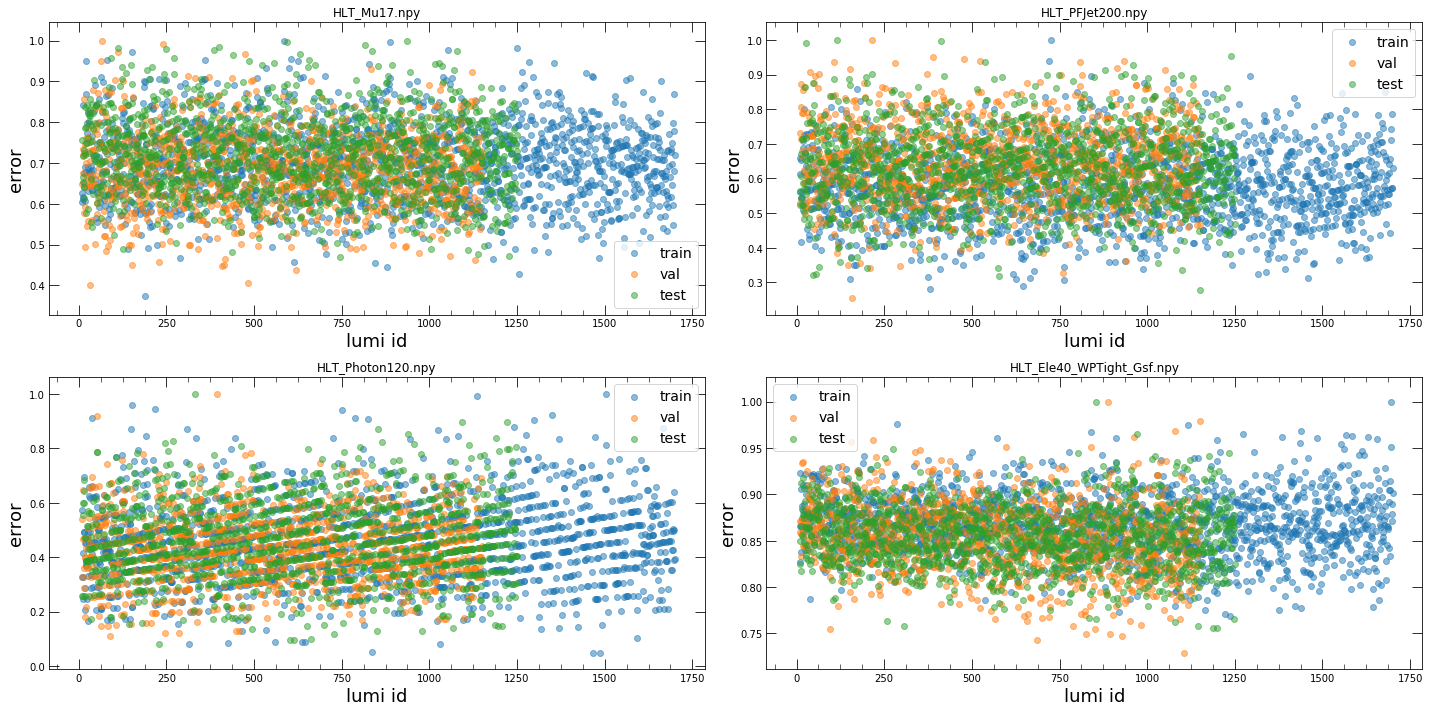

In [6]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [7]:
model_name = "simplest_5"

In [8]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20)                0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 63        
_________________________________________________________________
reconstructed (Dense)        (None, 20)                80        
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


Train on 1665 samples, validate on 1125 samples
Epoch 1/1000
 - 0s - loss: 1470.6378 - val_loss: 1453.2121
Epoch 2/1000
 - 0s - loss: 1437.5228 - val_loss: 1417.8954
Epoch 3/1000
 - 0s - loss: 1402.5606 - val_loss: 1383.2723
Epoch 4/1000
 - 0s - loss: 1368.2595 - val_loss: 1349.3556
Epoch 5/1000
 - 0s - loss: 1334.7080 - val_loss: 1316.1521
Epoch 6/1000
 - 0s - loss: 1301.8596 - val_loss: 1283.6746
Epoch 7/1000
 - 0s - loss: 1269.7107 - val_loss: 1251.9265
Epoch 8/1000
 - 0s - loss: 1238.3137 - val_loss: 1220.9086
Epoch 9/1000
 - 0s - loss: 1207.5870 - val_loss: 1190.6250
Epoch 10/1000
 - 0s - loss: 1177.6493 - val_loss: 1161.0673
Epoch 11/1000
 - 0s - loss: 1148.3654 - val_loss: 1132.0817
Epoch 12/1000
 - 0s - loss: 1119.6986 - val_loss: 1103.8196
Epoch 13/1000
 - 0s - loss: 1091.7987 - val_loss: 1076.4375
Epoch 14/1000
 - 0s - loss: 1064.7062 - val_loss: 1049.7631
Epoch 15/1000
 - 0s - loss: 1038.3482 - val_loss: 1023.7837
Epoch 16/1000
 - 0s - loss: 1012.6597 - val_loss: 998.4921
Ep

Epoch 141/1000
 - 0s - loss: 86.1910 - val_loss: 85.6632
Epoch 142/1000
 - 0s - loss: 84.8940 - val_loss: 84.3766
Epoch 143/1000
 - 0s - loss: 83.6197 - val_loss: 83.1160
Epoch 144/1000
 - 0s - loss: 82.3713 - val_loss: 81.8775
Epoch 145/1000
 - 0s - loss: 81.1446 - val_loss: 80.6609
Epoch 146/1000
 - 0s - loss: 79.9397 - val_loss: 79.4682
Epoch 147/1000
 - 0s - loss: 78.7578 - val_loss: 78.2973
Epoch 148/1000
 - 0s - loss: 77.5986 - val_loss: 77.1473
Epoch 149/1000
 - 0s - loss: 76.4599 - val_loss: 76.0181
Epoch 150/1000
 - 0s - loss: 75.3414 - val_loss: 74.9076
Epoch 151/1000
 - 0s - loss: 74.2422 - val_loss: 73.8187
Epoch 152/1000
 - 0s - loss: 73.1633 - val_loss: 72.7493
Epoch 153/1000
 - 0s - loss: 72.1037 - val_loss: 71.6976
Epoch 154/1000
 - 0s - loss: 71.0623 - val_loss: 70.6653
Epoch 155/1000
 - 0s - loss: 70.0396 - val_loss: 69.6512
Epoch 156/1000
 - 0s - loss: 69.0353 - val_loss: 68.6544
Epoch 157/1000
 - 0s - loss: 68.0476 - val_loss: 67.6759
Epoch 158/1000
 - 0s - loss: 67

Epoch 285/1000
 - 0s - loss: 14.6934 - val_loss: 14.6620
Epoch 286/1000
 - 0s - loss: 14.5455 - val_loss: 14.5146
Epoch 287/1000
 - 0s - loss: 14.3992 - val_loss: 14.3689
Epoch 288/1000
 - 0s - loss: 14.2546 - val_loss: 14.2249
Epoch 289/1000
 - 0s - loss: 14.1121 - val_loss: 14.0827
Epoch 290/1000
 - 0s - loss: 13.9711 - val_loss: 13.9423
Epoch 291/1000
 - 0s - loss: 13.8318 - val_loss: 13.8035
Epoch 292/1000
 - 0s - loss: 13.6941 - val_loss: 13.6664
Epoch 293/1000
 - 0s - loss: 13.5582 - val_loss: 13.5309
Epoch 294/1000
 - 0s - loss: 13.4239 - val_loss: 13.3971
Epoch 295/1000
 - 0s - loss: 13.2912 - val_loss: 13.2649
Epoch 296/1000
 - 0s - loss: 13.1601 - val_loss: 13.1343
Epoch 297/1000
 - 0s - loss: 13.0306 - val_loss: 13.0051
Epoch 298/1000
 - 0s - loss: 12.9025 - val_loss: 12.8776
Epoch 299/1000
 - 0s - loss: 12.7760 - val_loss: 12.7515
Epoch 300/1000
 - 0s - loss: 12.6510 - val_loss: 12.6270
Epoch 301/1000
 - 0s - loss: 12.5275 - val_loss: 12.5039
Epoch 302/1000
 - 0s - loss: 12

Epoch 433/1000
 - 0s - loss: 3.9568 - val_loss: 3.9547
Epoch 434/1000
 - 0s - loss: 3.9258 - val_loss: 3.9238
Epoch 435/1000
 - 0s - loss: 3.8951 - val_loss: 3.8931
Epoch 436/1000
 - 0s - loss: 3.8647 - val_loss: 3.8627
Epoch 437/1000
 - 0s - loss: 3.8345 - val_loss: 3.8326
Epoch 438/1000
 - 0s - loss: 3.8047 - val_loss: 3.8028
Epoch 439/1000
 - 0s - loss: 3.7750 - val_loss: 3.7732
Epoch 440/1000
 - 0s - loss: 3.7457 - val_loss: 3.7439
Epoch 441/1000
 - 0s - loss: 3.7166 - val_loss: 3.7149
Epoch 442/1000
 - 0s - loss: 3.6878 - val_loss: 3.6861
Epoch 443/1000
 - 0s - loss: 3.6593 - val_loss: 3.6576
Epoch 444/1000
 - 0s - loss: 3.6310 - val_loss: 3.6293
Epoch 445/1000
 - 0s - loss: 3.6029 - val_loss: 3.6013
Epoch 446/1000
 - 0s - loss: 3.5752 - val_loss: 3.5736
Epoch 447/1000
 - 0s - loss: 3.5476 - val_loss: 3.5461
Epoch 448/1000
 - 0s - loss: 3.5203 - val_loss: 3.5188
Epoch 449/1000
 - 0s - loss: 3.4933 - val_loss: 3.4918
Epoch 450/1000
 - 0s - loss: 3.4665 - val_loss: 3.4650
Epoch 451/

Epoch 582/1000
 - 0s - loss: 1.3467 - val_loss: 1.3465
Epoch 583/1000
 - 0s - loss: 1.3377 - val_loss: 1.3375
Epoch 584/1000
 - 0s - loss: 1.3287 - val_loss: 1.3286
Epoch 585/1000
 - 0s - loss: 1.3198 - val_loss: 1.3197
Epoch 586/1000
 - 0s - loss: 1.3110 - val_loss: 1.3109
Epoch 587/1000
 - 0s - loss: 1.3023 - val_loss: 1.3021
Epoch 588/1000
 - 0s - loss: 1.2936 - val_loss: 1.2934
Epoch 589/1000
 - 0s - loss: 1.2850 - val_loss: 1.2848
Epoch 590/1000
 - 0s - loss: 1.2764 - val_loss: 1.2763
Epoch 591/1000
 - 0s - loss: 1.2679 - val_loss: 1.2678
Epoch 592/1000
 - 0s - loss: 1.2595 - val_loss: 1.2593
Epoch 593/1000
 - 0s - loss: 1.2511 - val_loss: 1.2510
Epoch 594/1000
 - 0s - loss: 1.2428 - val_loss: 1.2427
Epoch 595/1000
 - 0s - loss: 1.2346 - val_loss: 1.2344
Epoch 596/1000
 - 0s - loss: 1.2264 - val_loss: 1.2263
Epoch 597/1000
 - 0s - loss: 1.2183 - val_loss: 1.2181
Epoch 598/1000
 - 0s - loss: 1.2102 - val_loss: 1.2101
Epoch 599/1000
 - 0s - loss: 1.2022 - val_loss: 1.2021
Epoch 600/

Epoch 731/1000
 - 0s - loss: 0.5208 - val_loss: 0.5204
Epoch 732/1000
 - 0s - loss: 0.5176 - val_loss: 0.5173
Epoch 733/1000
 - 0s - loss: 0.5145 - val_loss: 0.5141
Epoch 734/1000
 - 0s - loss: 0.5114 - val_loss: 0.5110
Epoch 735/1000
 - 0s - loss: 0.5083 - val_loss: 0.5079
Epoch 736/1000
 - 0s - loss: 0.5052 - val_loss: 0.5048
Epoch 737/1000
 - 0s - loss: 0.5021 - val_loss: 0.5018
Epoch 738/1000
 - 0s - loss: 0.4991 - val_loss: 0.4987
Epoch 739/1000
 - 0s - loss: 0.4961 - val_loss: 0.4957
Epoch 740/1000
 - 0s - loss: 0.4931 - val_loss: 0.4927
Epoch 741/1000
 - 0s - loss: 0.4901 - val_loss: 0.4897
Epoch 742/1000
 - 0s - loss: 0.4871 - val_loss: 0.4867
Epoch 743/1000
 - 0s - loss: 0.4842 - val_loss: 0.4838
Epoch 744/1000
 - 0s - loss: 0.4813 - val_loss: 0.4809
Epoch 745/1000
 - 0s - loss: 0.4784 - val_loss: 0.4780
Epoch 746/1000
 - 0s - loss: 0.4755 - val_loss: 0.4751
Epoch 747/1000
 - 0s - loss: 0.4726 - val_loss: 0.4722
Epoch 748/1000
 - 0s - loss: 0.4698 - val_loss: 0.4694
Epoch 749/

Epoch 880/1000
 - 0s - loss: 0.2168 - val_loss: 0.2163
Epoch 881/1000
 - 0s - loss: 0.2156 - val_loss: 0.2150
Epoch 882/1000
 - 0s - loss: 0.2144 - val_loss: 0.2138
Epoch 883/1000
 - 0s - loss: 0.2132 - val_loss: 0.2126
Epoch 884/1000
 - 0s - loss: 0.2120 - val_loss: 0.2114
Epoch 885/1000
 - 0s - loss: 0.2108 - val_loss: 0.2102
Epoch 886/1000
 - 0s - loss: 0.2096 - val_loss: 0.2090
Epoch 887/1000
 - 0s - loss: 0.2084 - val_loss: 0.2078
Epoch 888/1000
 - 0s - loss: 0.2072 - val_loss: 0.2066
Epoch 889/1000
 - 0s - loss: 0.2060 - val_loss: 0.2055
Epoch 890/1000
 - 0s - loss: 0.2049 - val_loss: 0.2043
Epoch 891/1000
 - 0s - loss: 0.2037 - val_loss: 0.2031
Epoch 892/1000
 - 0s - loss: 0.2026 - val_loss: 0.2020
Epoch 893/1000
 - 0s - loss: 0.2014 - val_loss: 0.2008
Epoch 894/1000
 - 0s - loss: 0.2003 - val_loss: 0.1997
Epoch 895/1000
 - 0s - loss: 0.1991 - val_loss: 0.1986
Epoch 896/1000
 - 0s - loss: 0.1980 - val_loss: 0.1975
Epoch 897/1000
 - 0s - loss: 0.1969 - val_loss: 0.1963
Epoch 898/

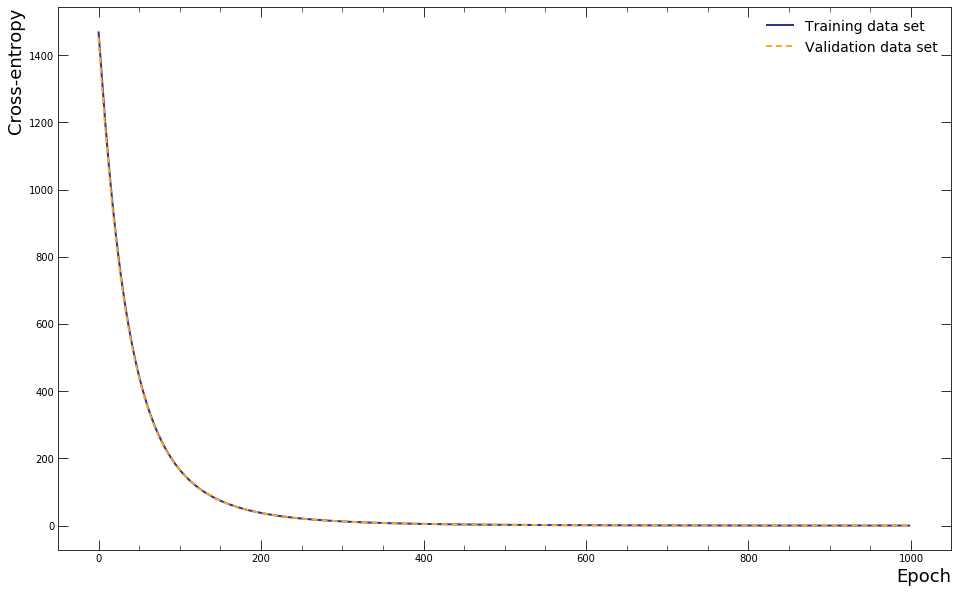

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

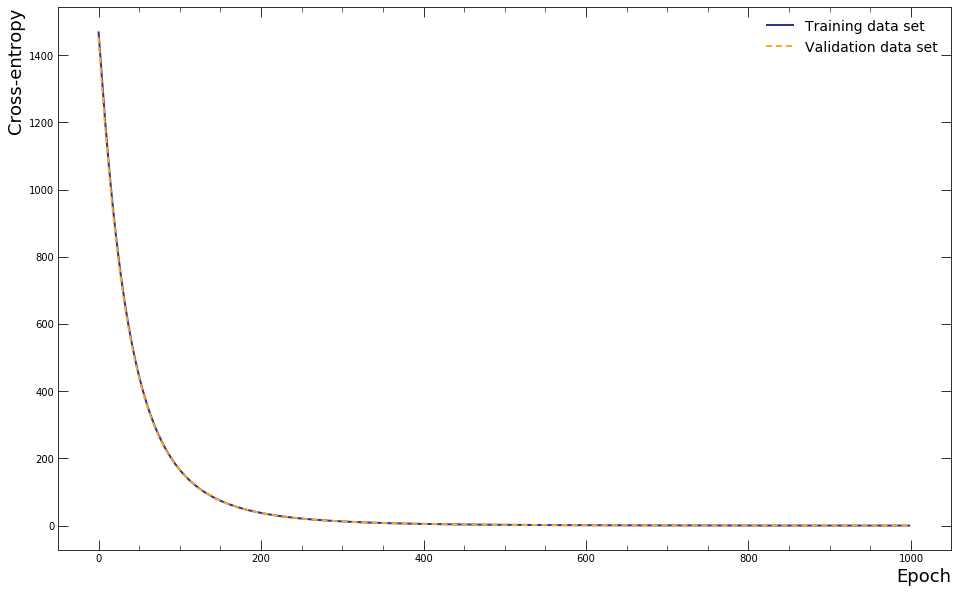

In [10]:
plot_loss(history)

## Training Data

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [12]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train[i][WINDOW*j])

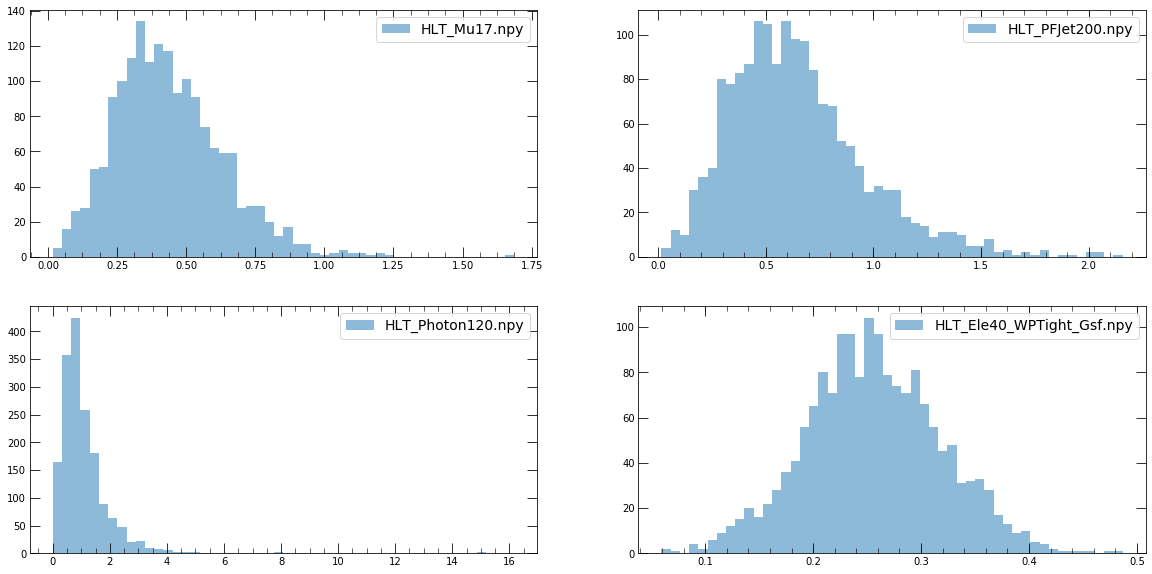

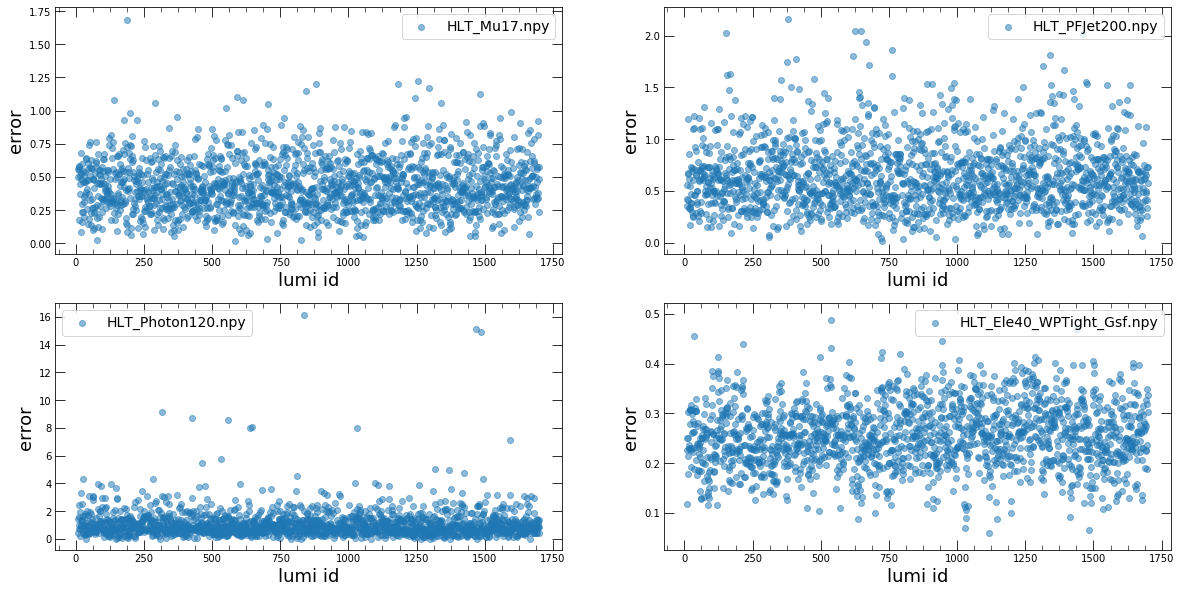

In [13]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

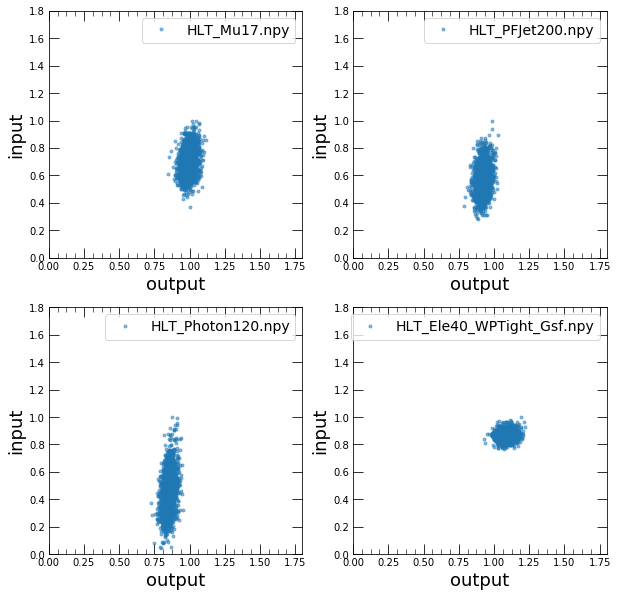

In [14]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.xlim(0,1.8)
    plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [15]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [16]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

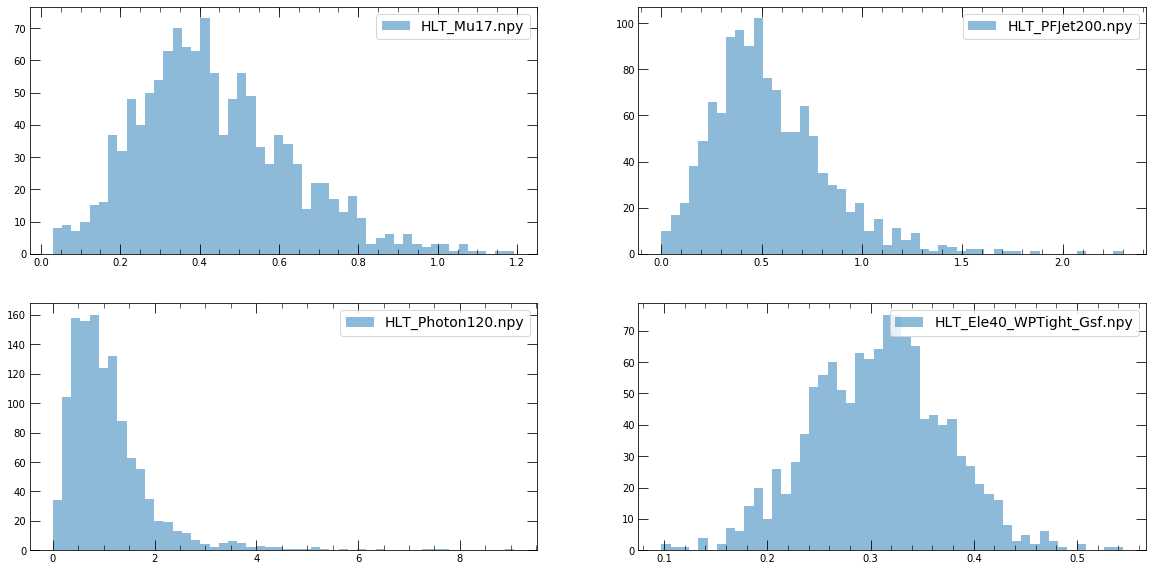

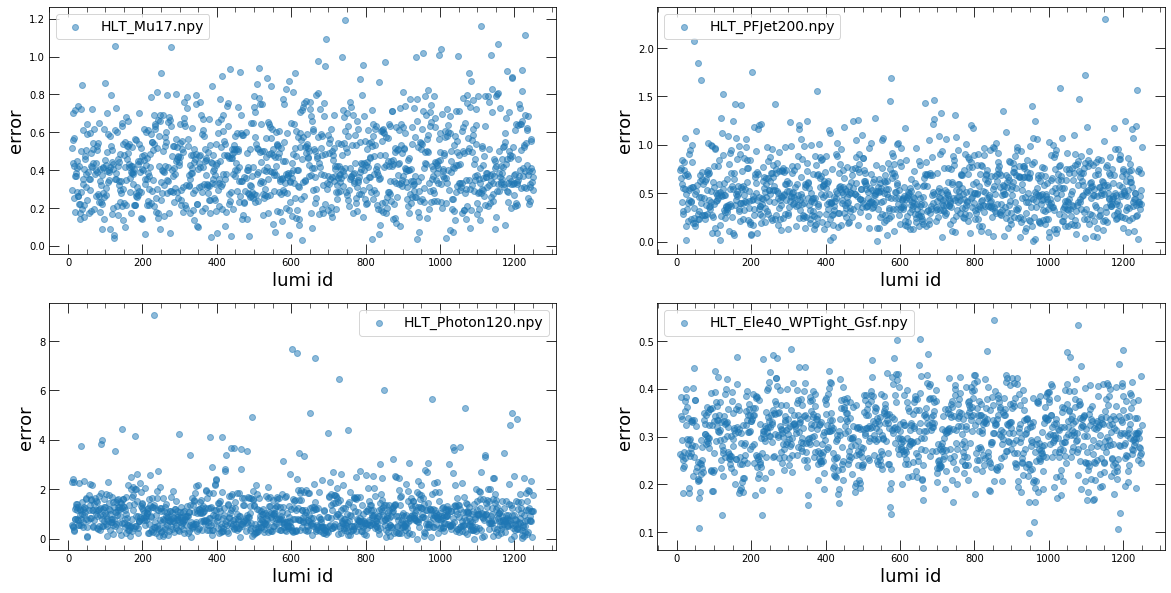

In [17]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

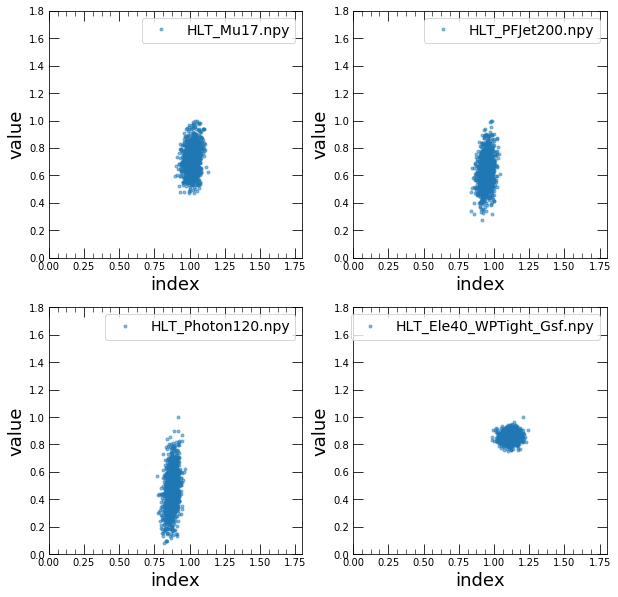

In [18]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,1.8)
    plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [19]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [20]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [21]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [22]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [23]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


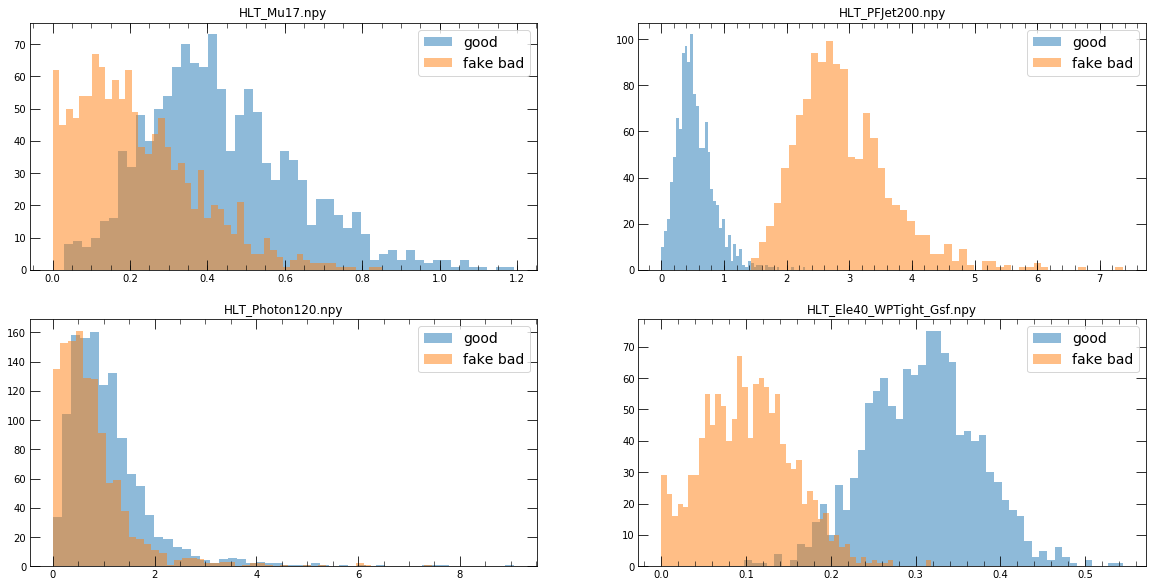

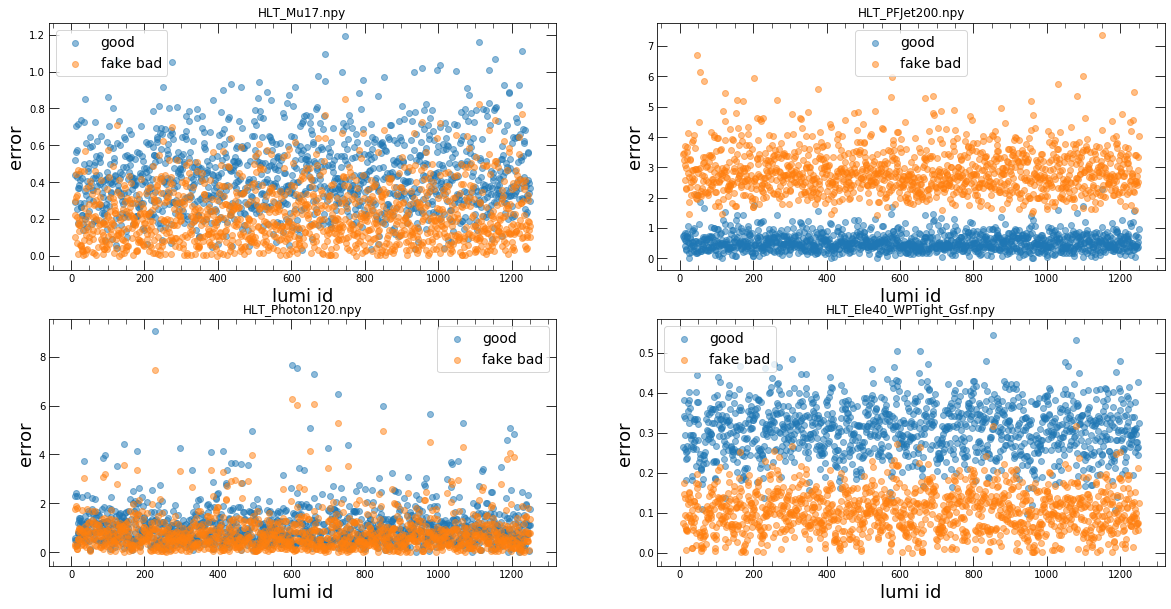

In [24]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

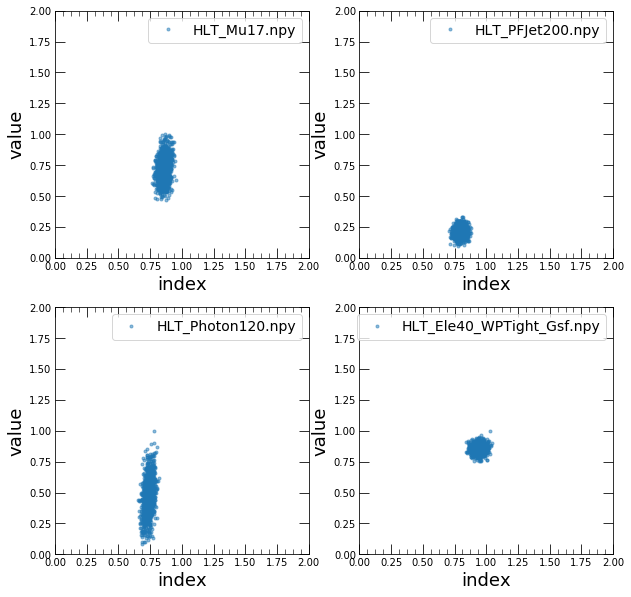

In [25]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,2)
    plt.ylim(0,2)
    plt.legend()    

plt.show()

In [26]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [27]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [28]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [29]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [30]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


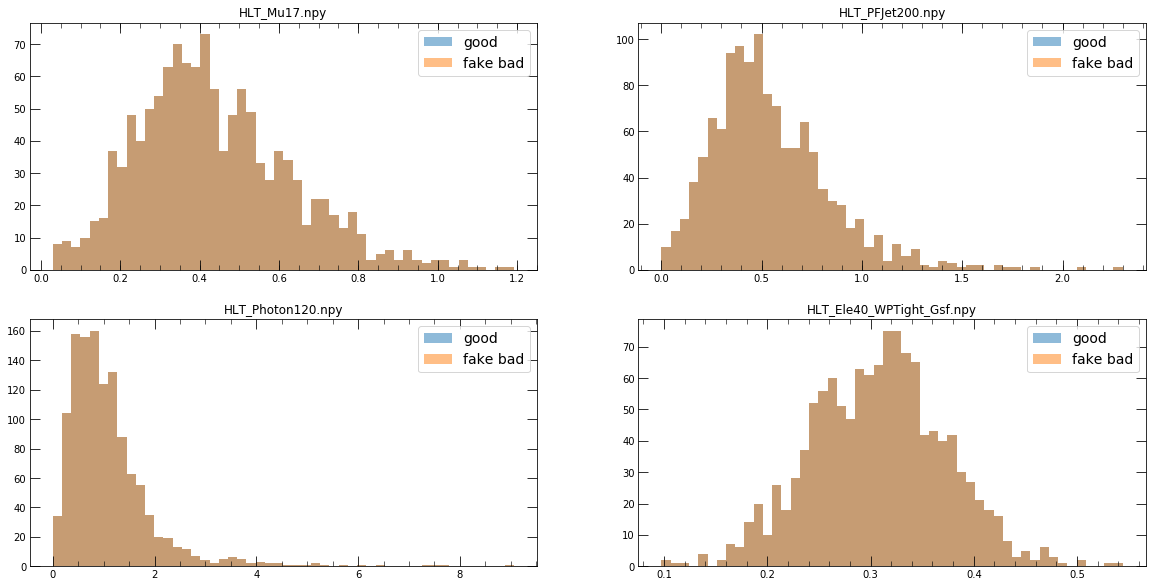

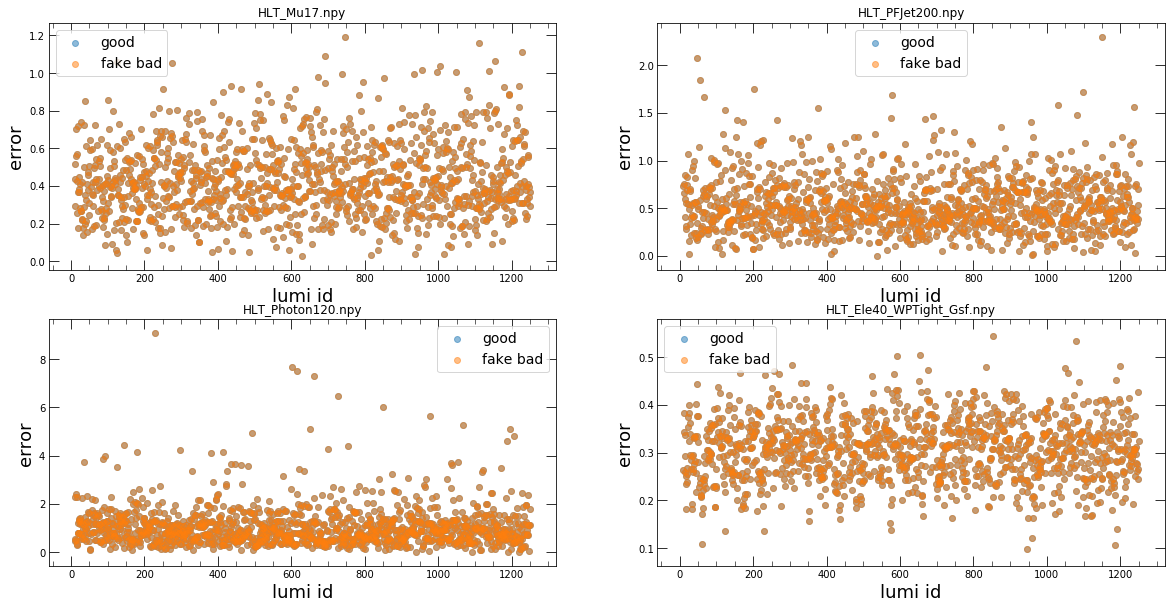

In [31]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

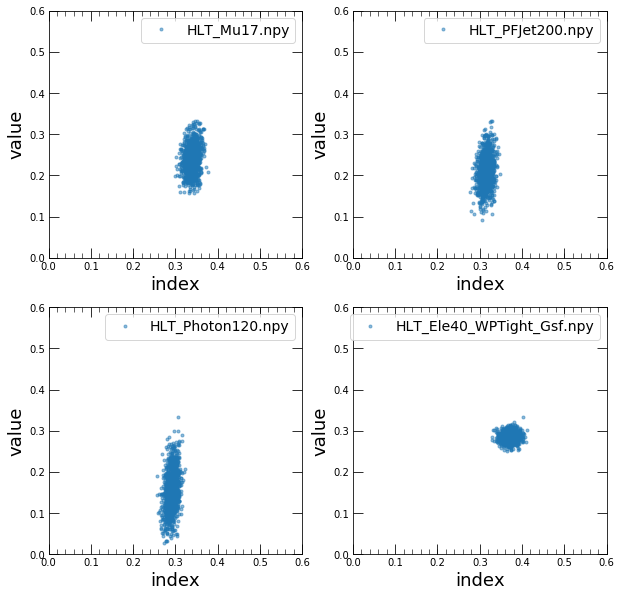

In [32]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [33]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [34]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [35]:
bad_runs = [305588]

with open('bad_data_WINDOW5.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [36]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [37]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


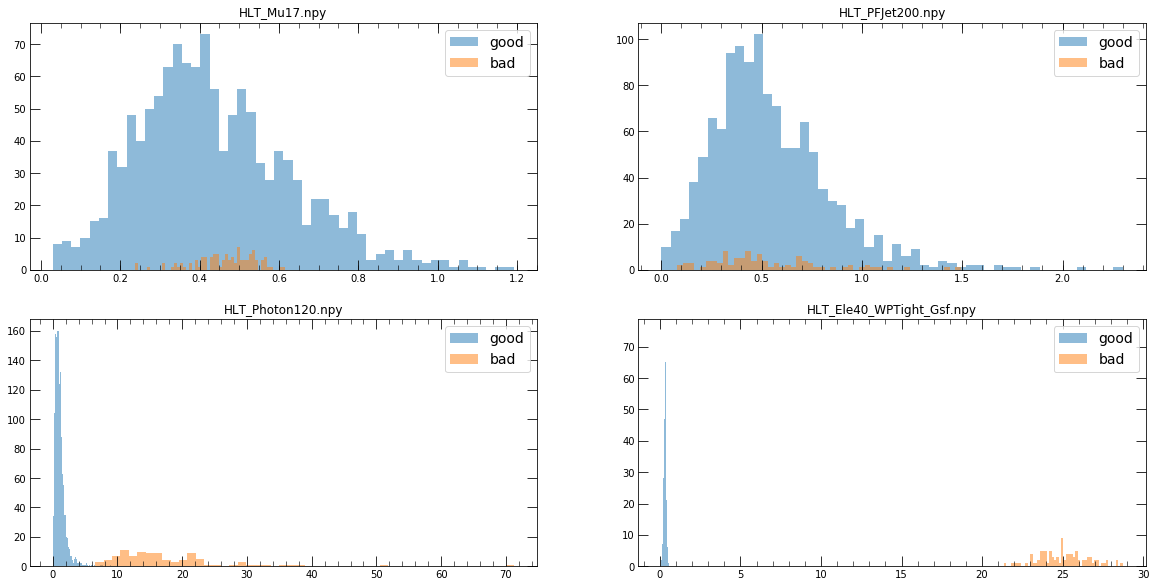

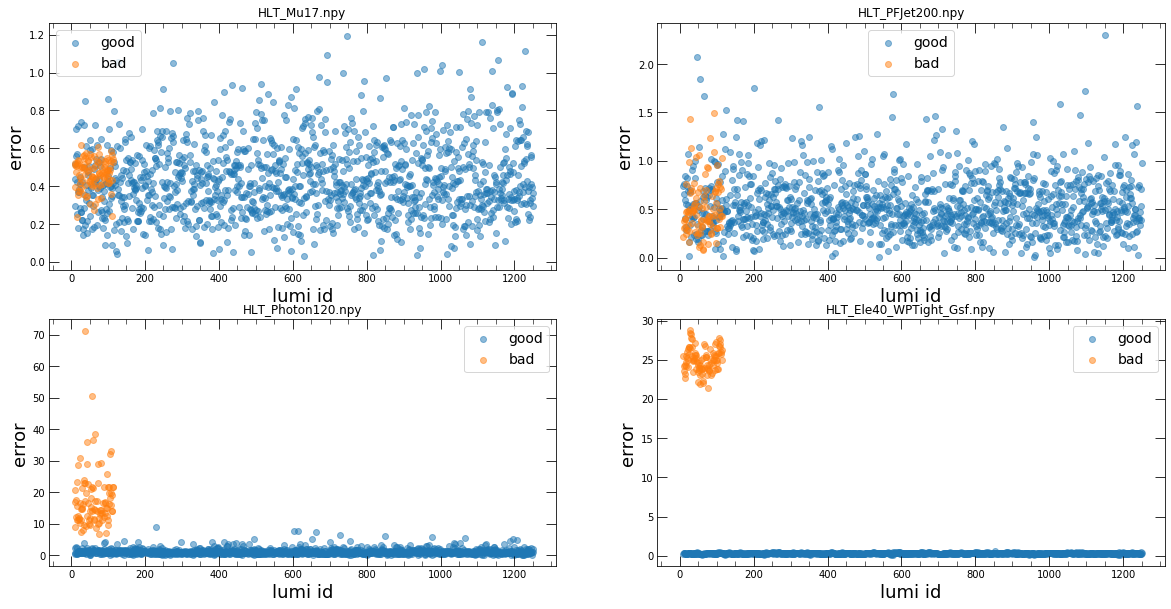

In [38]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

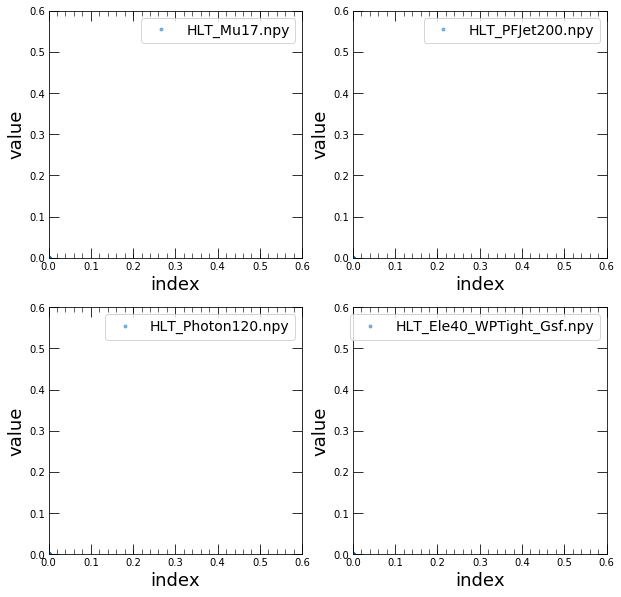

In [39]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [40]:
bad_runs = [301480]

with open('bad_data_WINDOW5.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [41]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [42]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


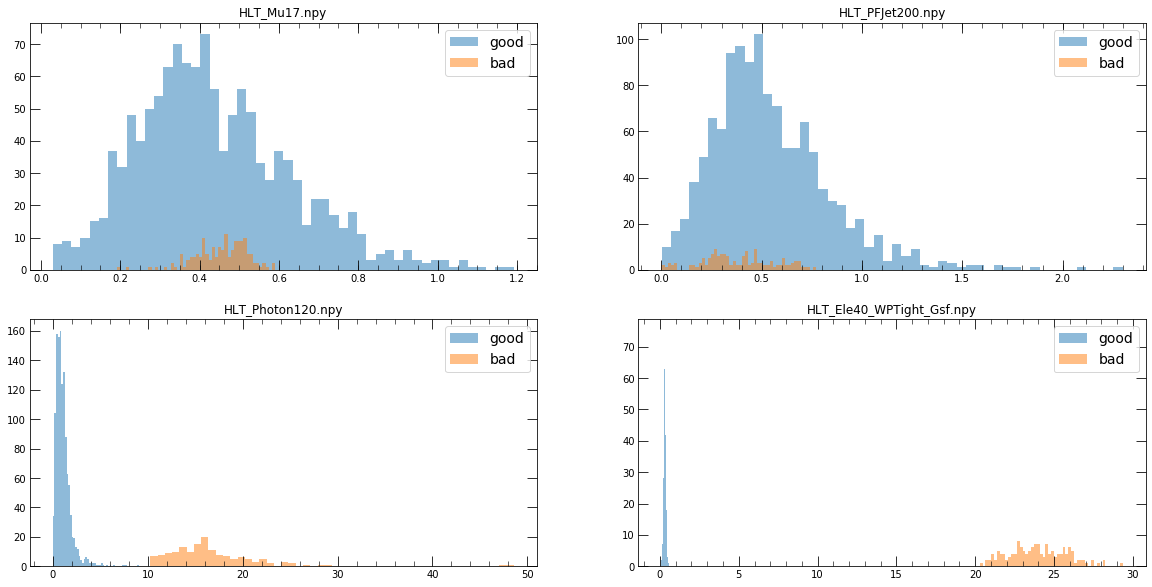

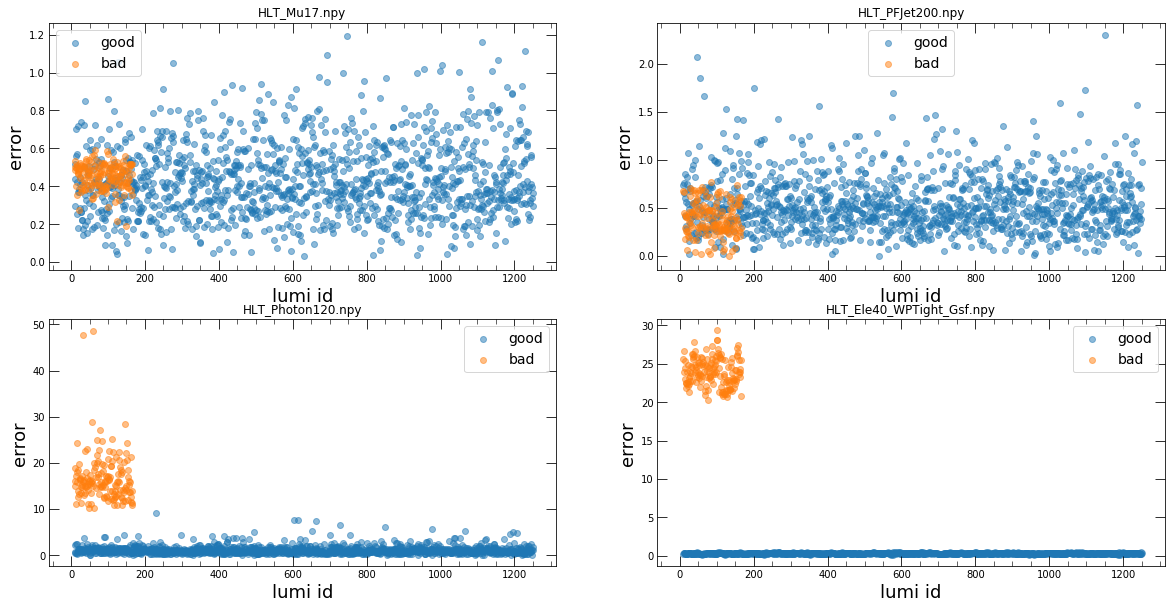

In [43]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

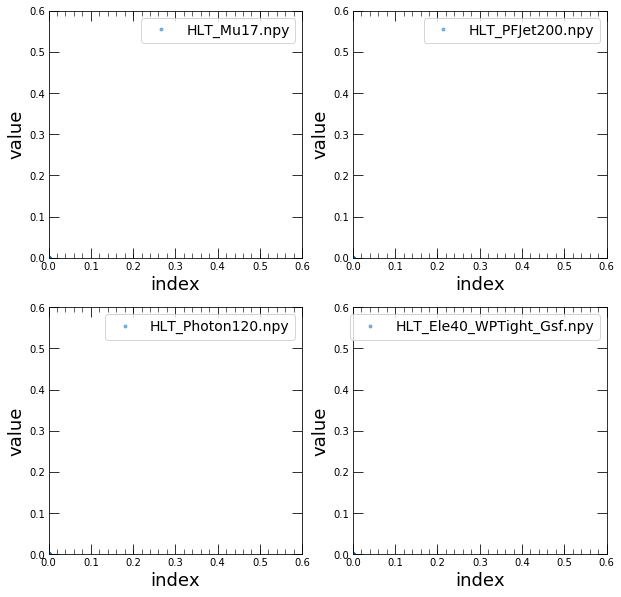

In [44]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()